# 1. Описание задачи и данных <a name="introduction"></a>

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Данные состоят из файлов, полученных из разных источников:**
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).

## 1.1 Первичный анализ данных <a name="paragraph1"></a>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (16,8)
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor

In [6]:
try:
    data_arc = pd.read_csv('/content/drive/MyDrive/Projects/ynd/on GitHub/industry data/data_arc_new.csv')
    data_bulk = pd.read_csv('/content/drive/MyDrive/Projects/ynd/on GitHub/industry data/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/content/drive/MyDrive/Projects/ynd/on GitHub/industry data/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/content/drive/MyDrive/Projects/ynd/on GitHub/industry data/data_gas_new.csv')
    data_temp = pd.read_csv('/content/drive/MyDrive/Projects/ynd/on GitHub/industry data/data_temp_new.csv')
    data_wire = pd.read_csv('/content/drive/MyDrive/Projects/ynd/on GitHub/industry data/data_wire_new.csv')
    data_wire_time = pd.read_csv('/content/drive/MyDrive/Projects/ynd/on GitHub/industry data/data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

### 1.1.1 Данные об электродах <a name="paragraph2"></a>

In [7]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [8]:
data_arc.info()
data_arc.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [9]:
len(data_arc['key'].unique())

3214

In [10]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

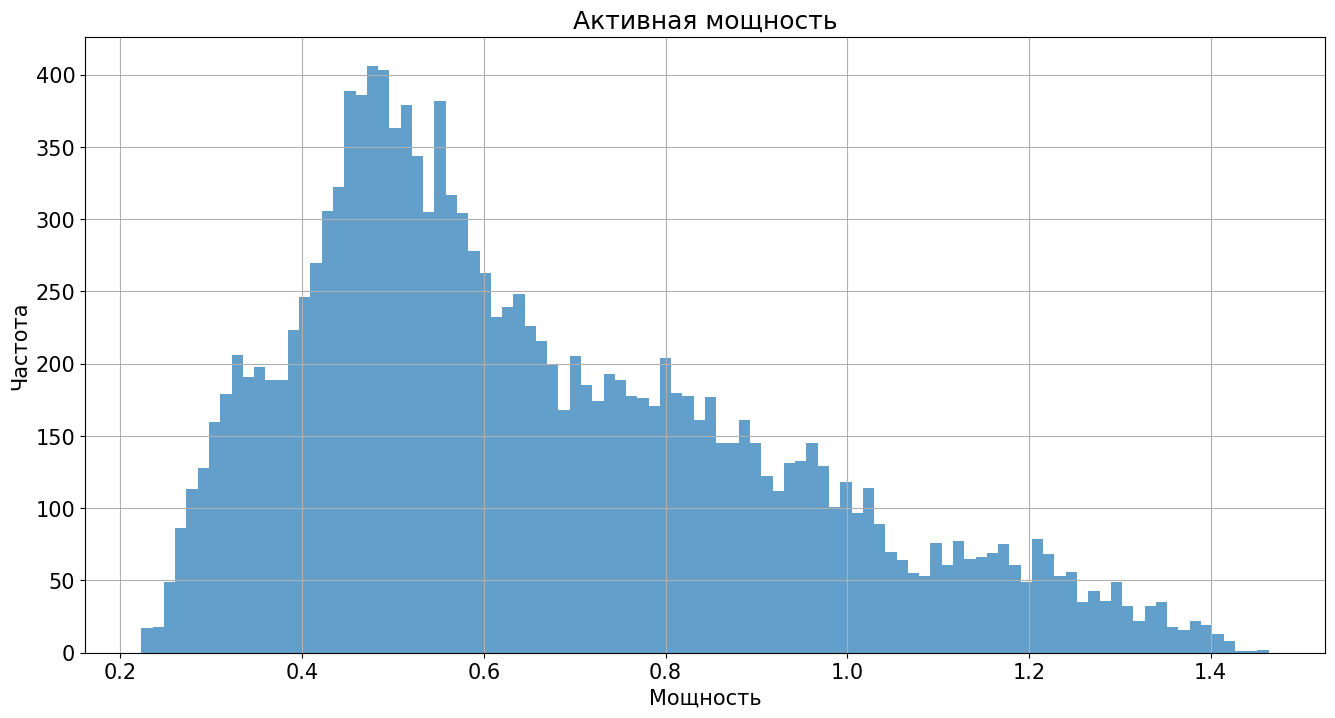

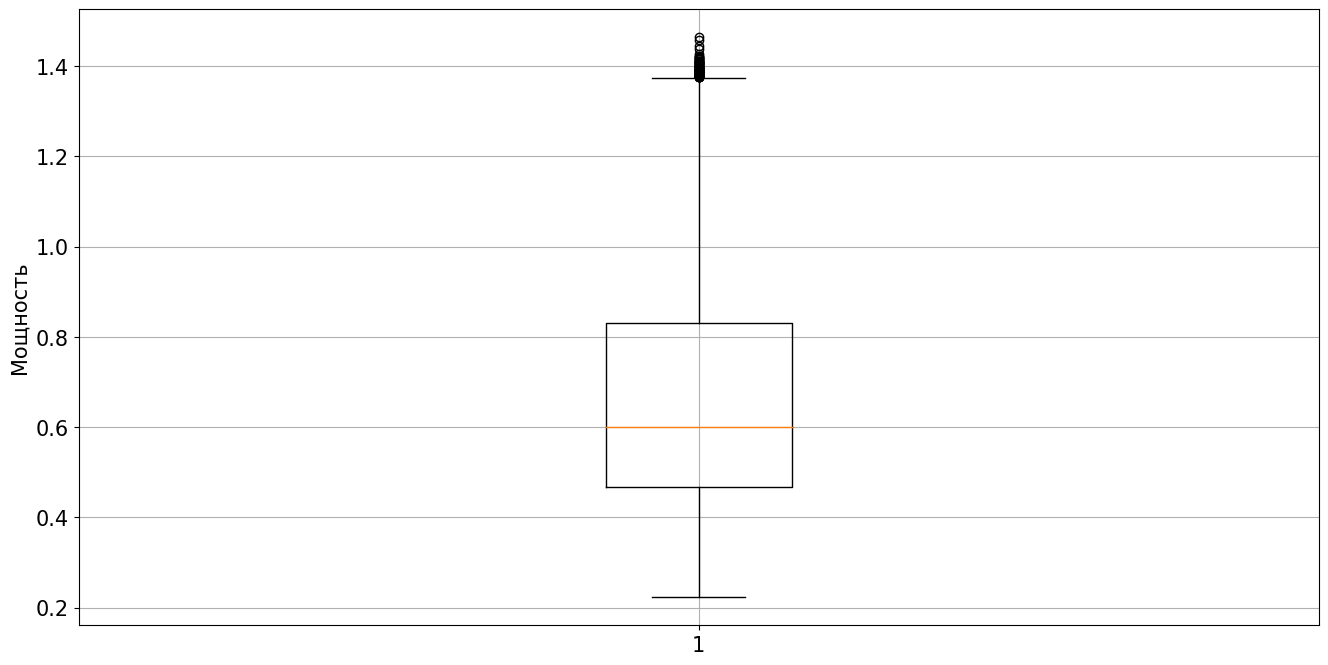

In [11]:
plt.hist(data_arc['Активная мощность'], bins=100, alpha=.7)
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.title('Активная мощность')
plt.grid(True)
plt.show()

plt.boxplot(data_arc['Активная мощность'])
plt.ylabel('Мощность')
plt.grid(True)
plt.show()

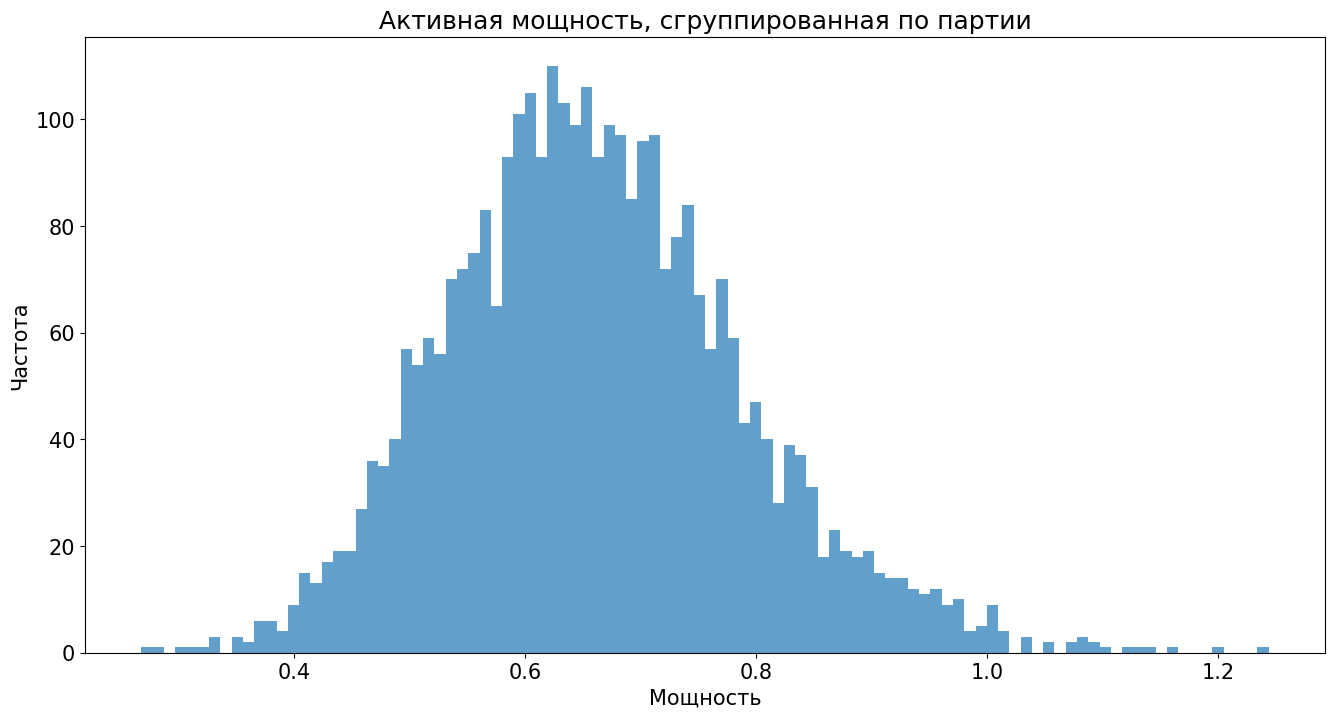

In [12]:
plt.hist(data_arc.groupby('key')['Активная мощность'].mean(), bins=100, alpha=.7)
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.title('Активная мощность, сгруппированная по партии')
plt.show()

In [13]:
data_arc[data_arc['Реактивная мощность'] < 0]['Реактивная мощность'].count()

1

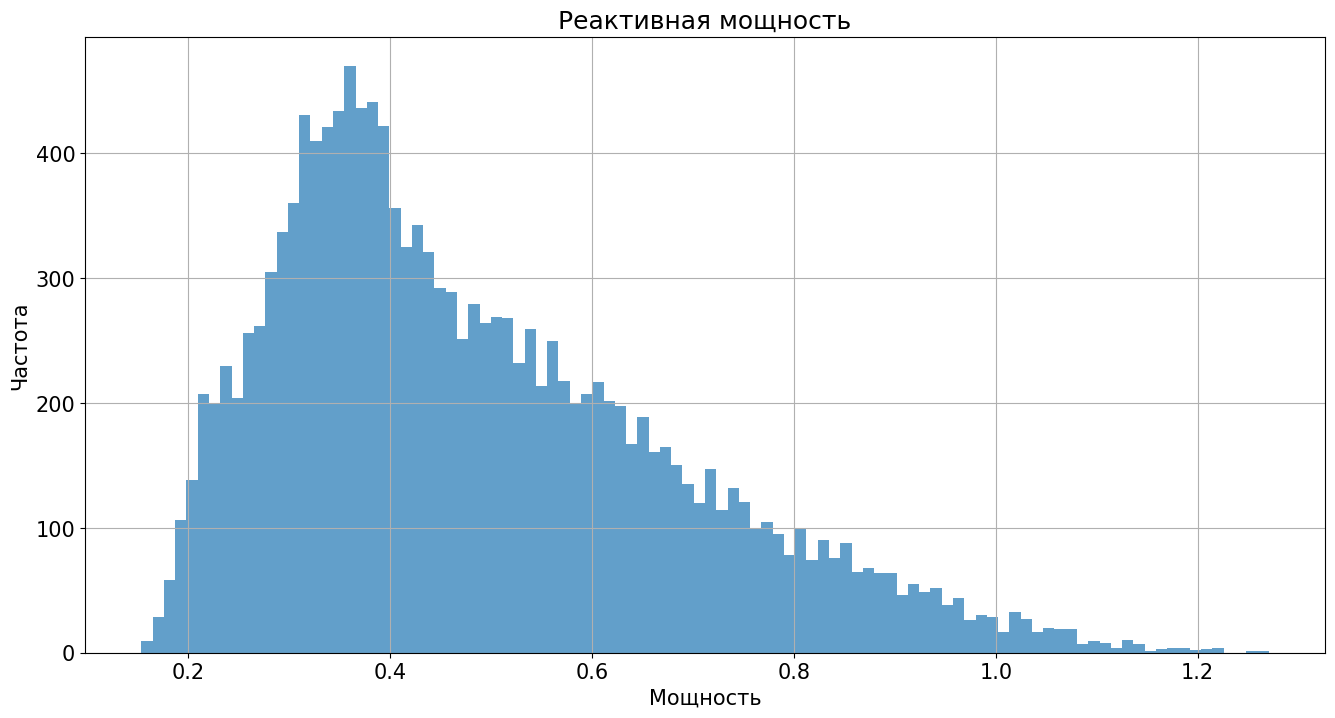

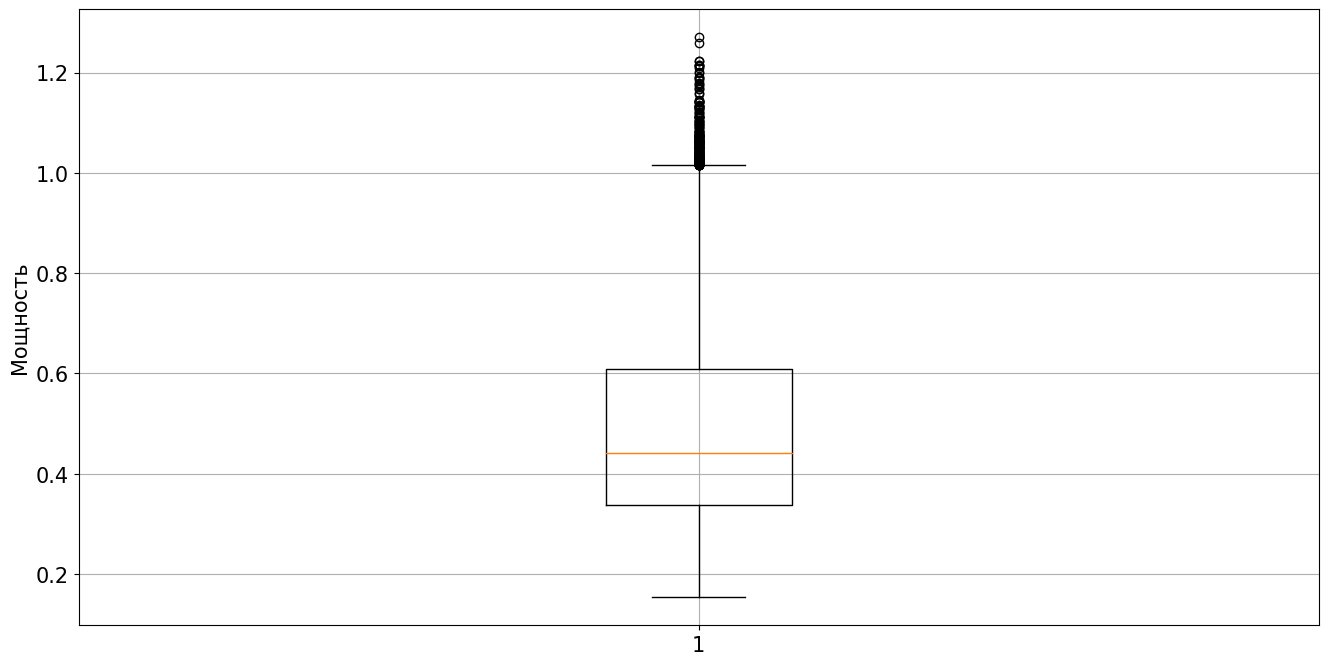

In [14]:
plt.hist(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'], bins=100, alpha=.7)
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.title('Реактивная мощность')
plt.grid(True)
plt.show()

plt.boxplot(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'])
plt.ylabel('Мощность')
plt.grid(True)
plt.show()

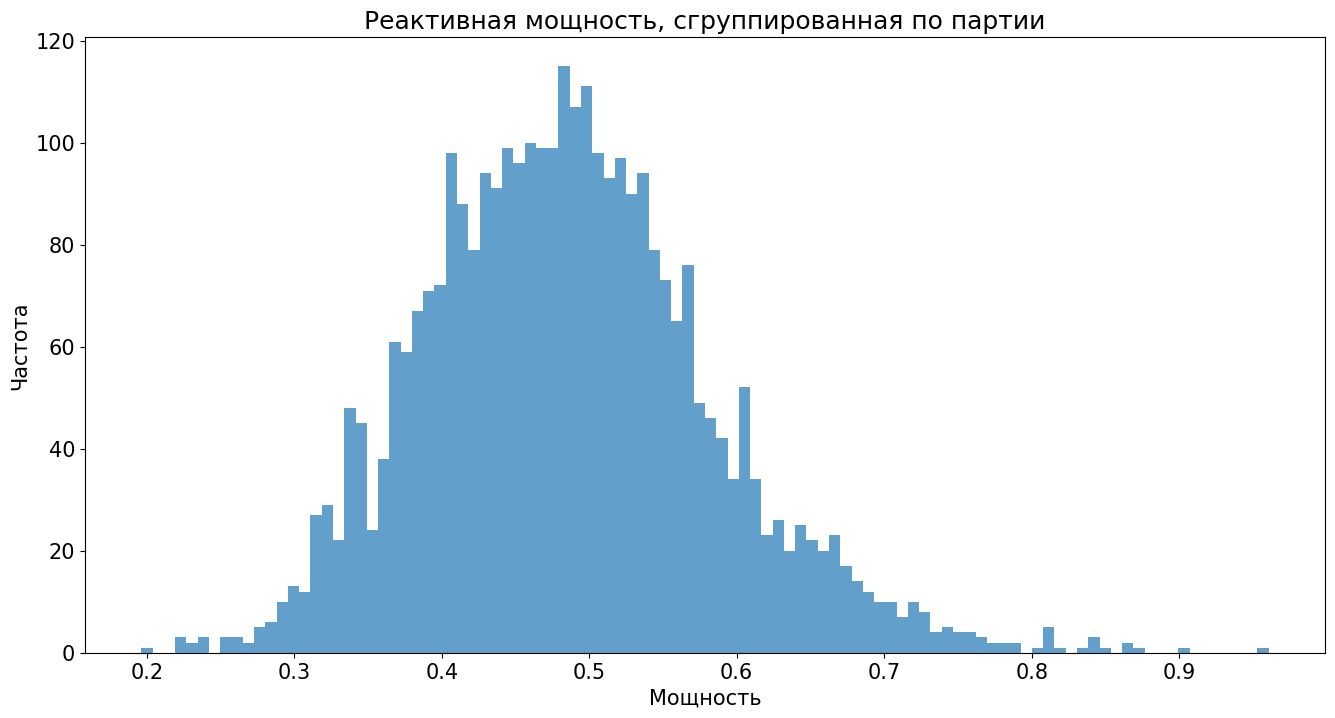

In [15]:
plt.hist(data_arc[data_arc['Реактивная мощность'] > 0]
         .groupby('key')['Реактивная мощность'].mean(), bins=100, alpha=.7)
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.title('Реактивная мощность, сгруппированная по партии')
plt.show()

**Вывод:**
* данные чистые, нет пропусков и дубликатов
* преобразовал время начала и конца нагрева в нужный формат
* в колонке "Реактивная мощность" есть одно отрицательное значение
* значения активной и реактивной мощностей смещены влево
* если сгруппировать данные по партиям и рассчитать средние значения мощностей, то распределение приближается к нормальному

### 1.1.2 Данные о подаче сыпучих материалов (объём) <a name="paragraph3"></a>

In [16]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [17]:
data_bulk.info()
data_bulk.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [18]:
len(data_bulk['key'].unique())

3129

In [19]:
data_bulk.isnull().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [20]:
data_bulk.duplicated().sum()

0

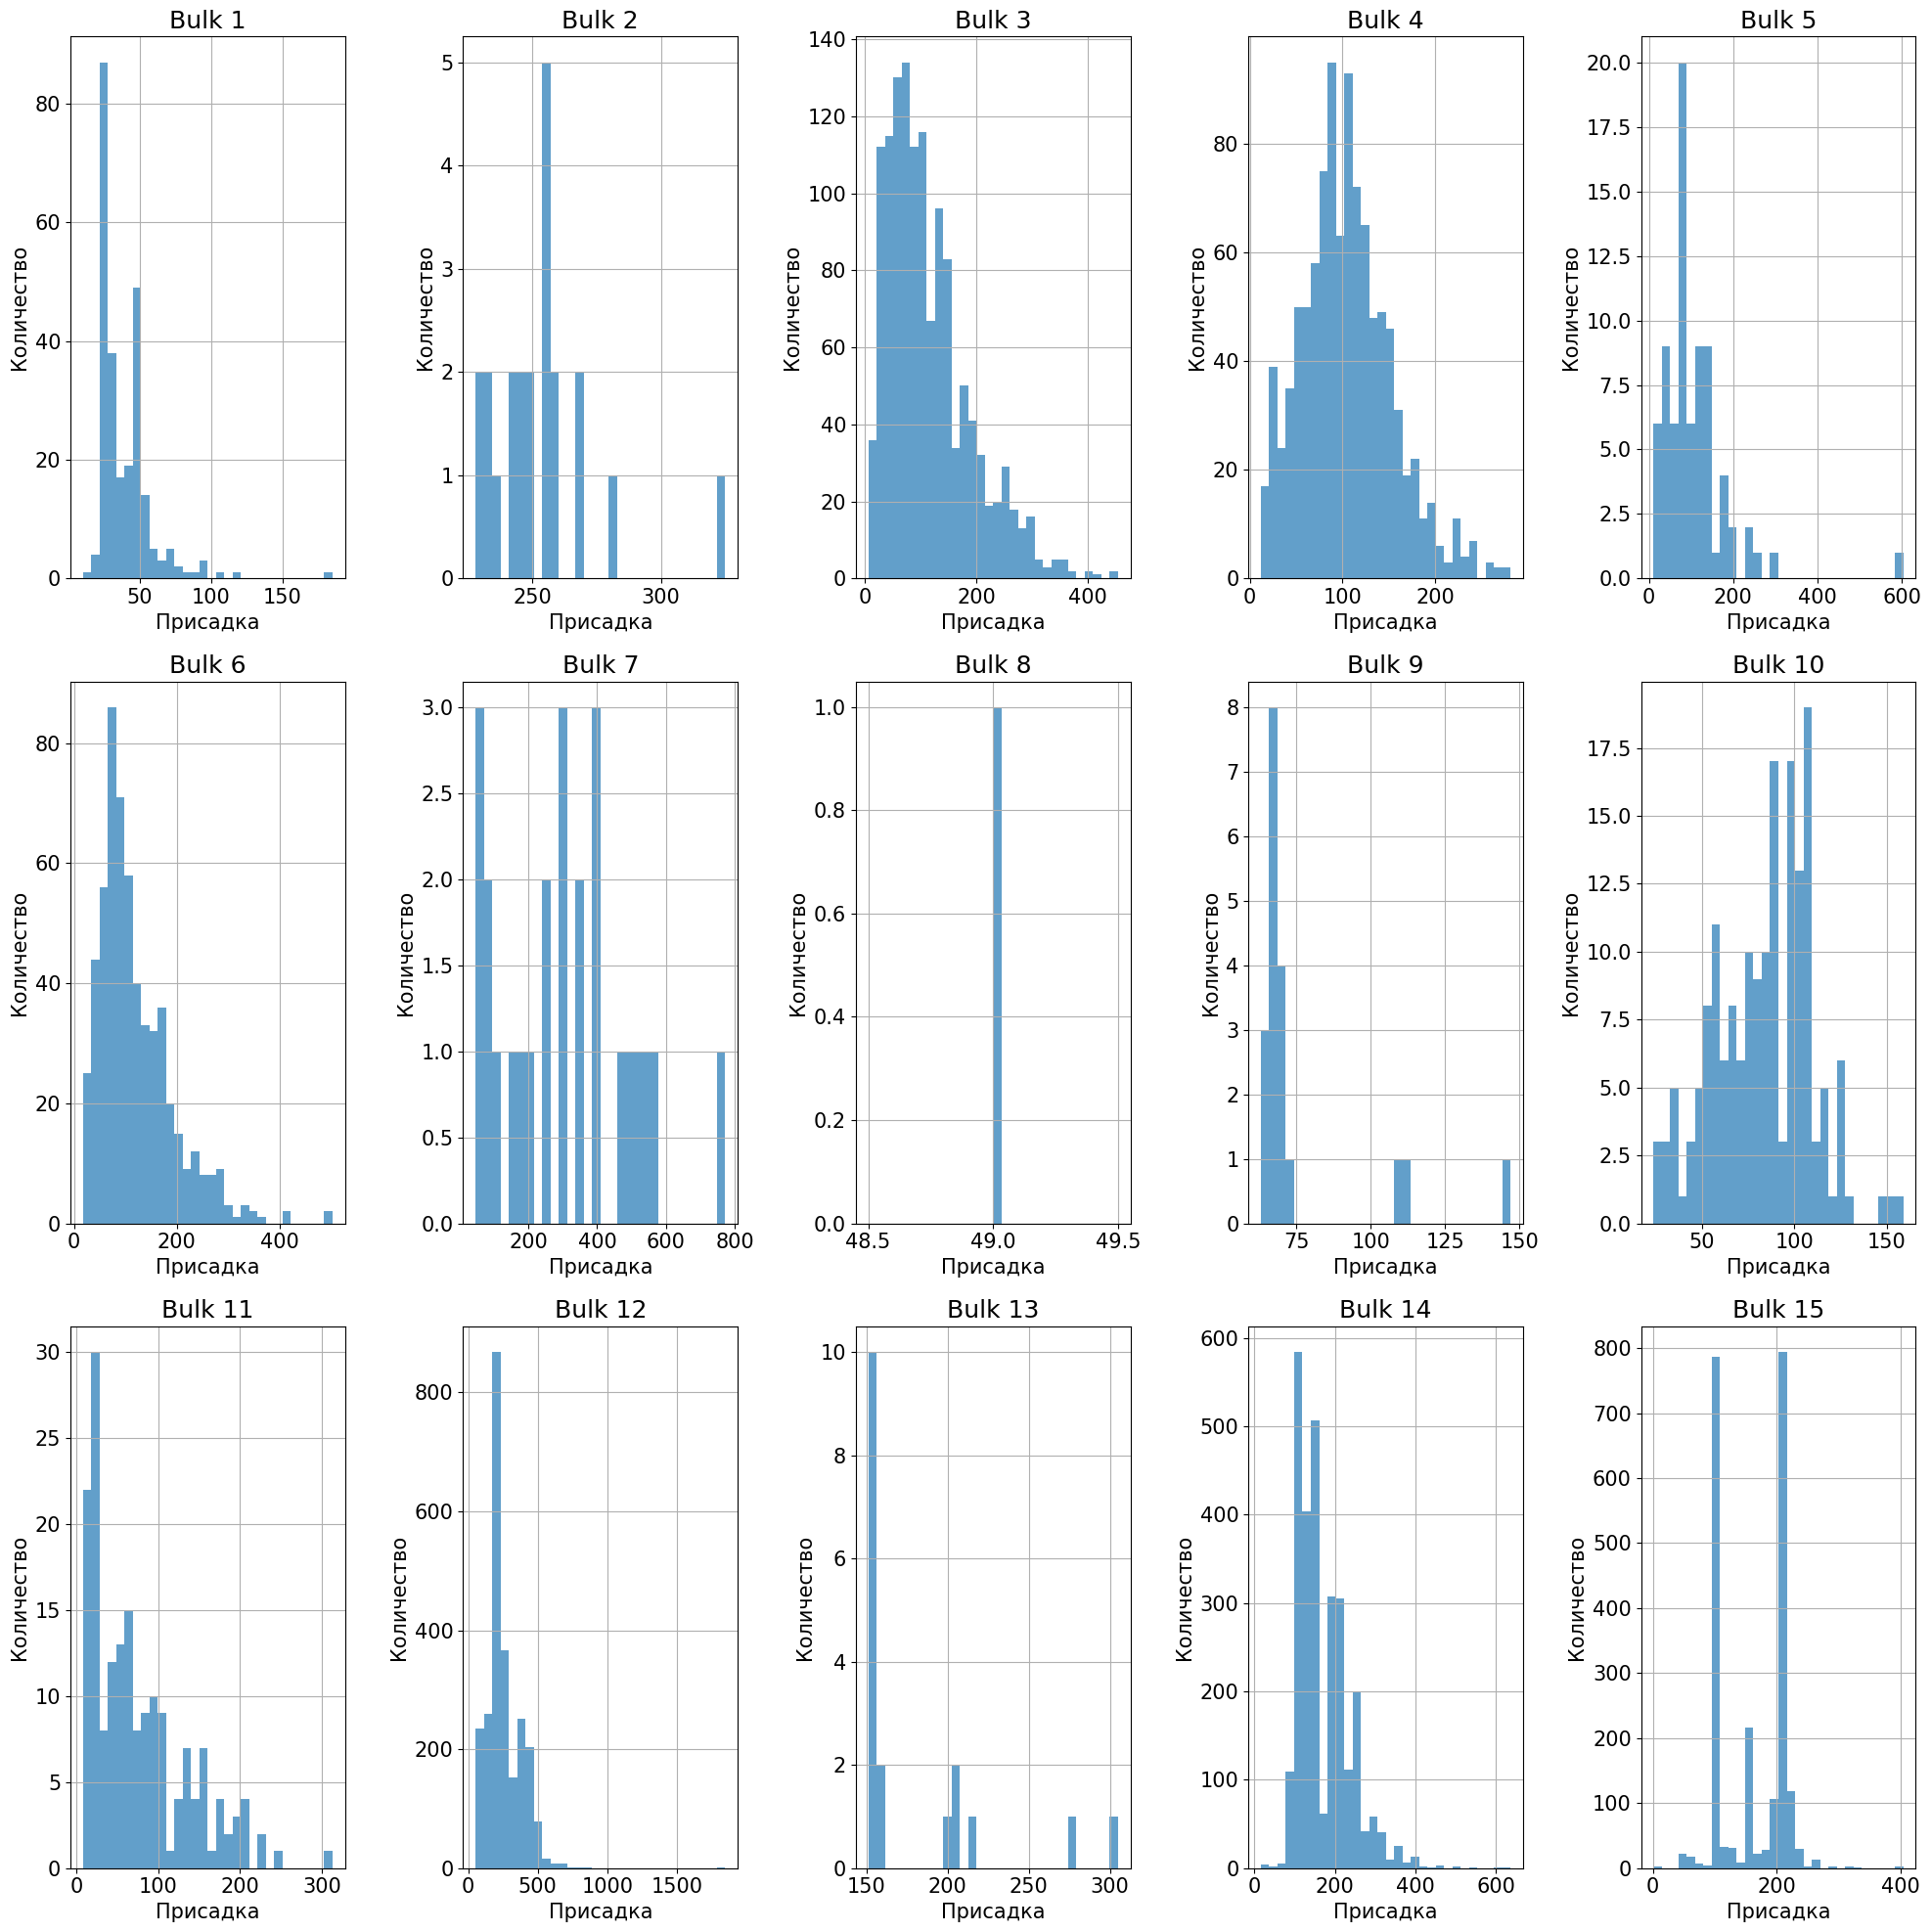

In [21]:
df = data_bulk.drop(['key'], axis=1)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 20))

for i, column in enumerate(df.columns):
    row, col = i // 5, i % 5
    axes[row, col].hist(df[column], bins=30, alpha=0.7)
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel('Присадка')
    axes[row, col].set_ylabel('Количество')
    axes[row, col].grid(True)
plt.tight_layout()
plt.show()

### Данные о подаче сыпучих материалов (время)

In [22]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [23]:
data_bulk_time.info()
data_bulk_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


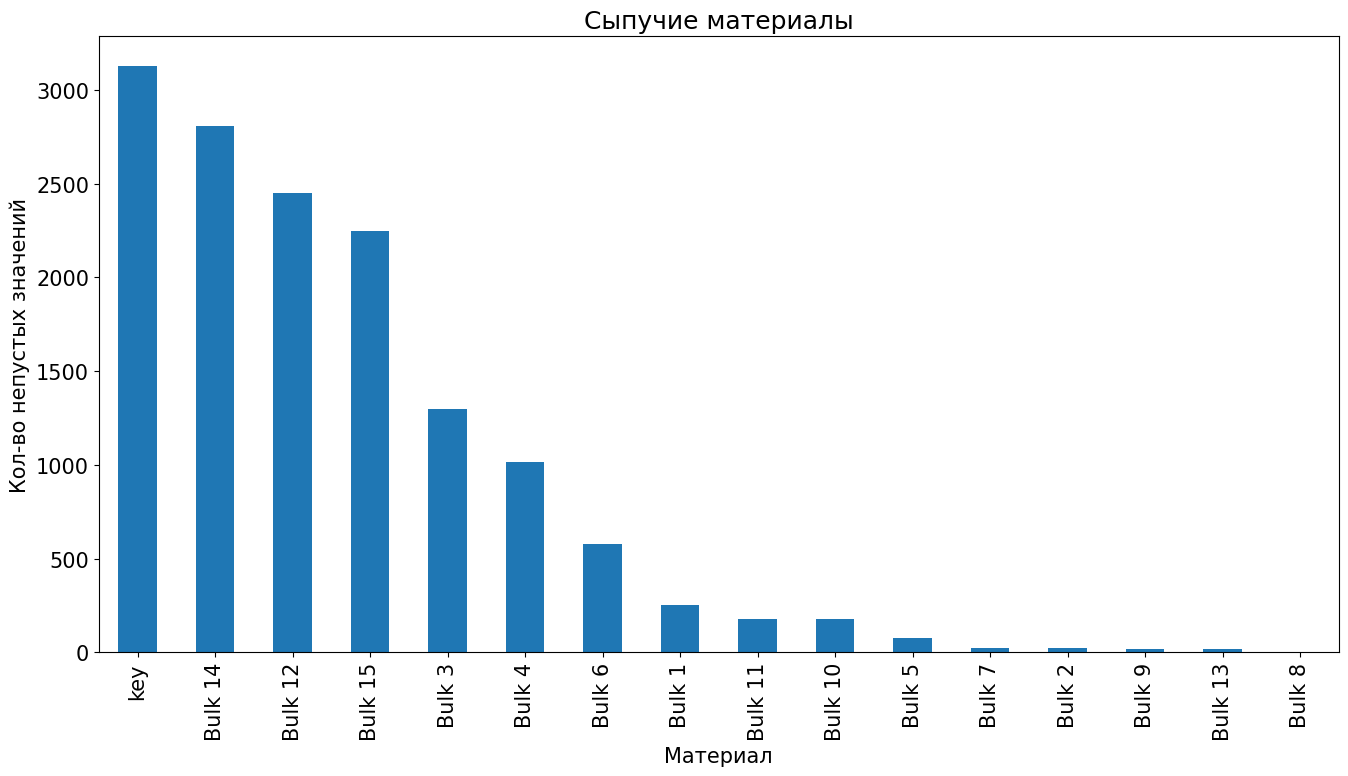

In [24]:
data_bulk_time.notnull().sum().sort_values(ascending=False).plot(kind = 'bar')
plt.xlabel('Материал')
plt.ylabel('Кол-во непустых значений')
plt.title('Сыпучие материалы')
plt.show()

**Вывод:**
* данные и пропуски в датасетах data_bulk и data_bulk_time идентичны
* большая часть данных отсутсвует, скорее всего это отображает популярность материалов в производстве. Например, Bulk 14 применяют почти во всех партиях
* из этого следует, что пропуски заполнить нечем, т.к. материал не используют в производстве некоторых партий
* скорее всего цифры в data_bulk показывают массу или объем материала для сплава, эту деталь нужно узнать у бизнеса
* все номера партии (key) — уникальные


### 1.1.3 Данные о продувке сплава газом <a name="paragraph4"></a>

In [25]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [26]:
data_gas.info()
data_gas.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [27]:
len(data_gas['key'].unique())

3239

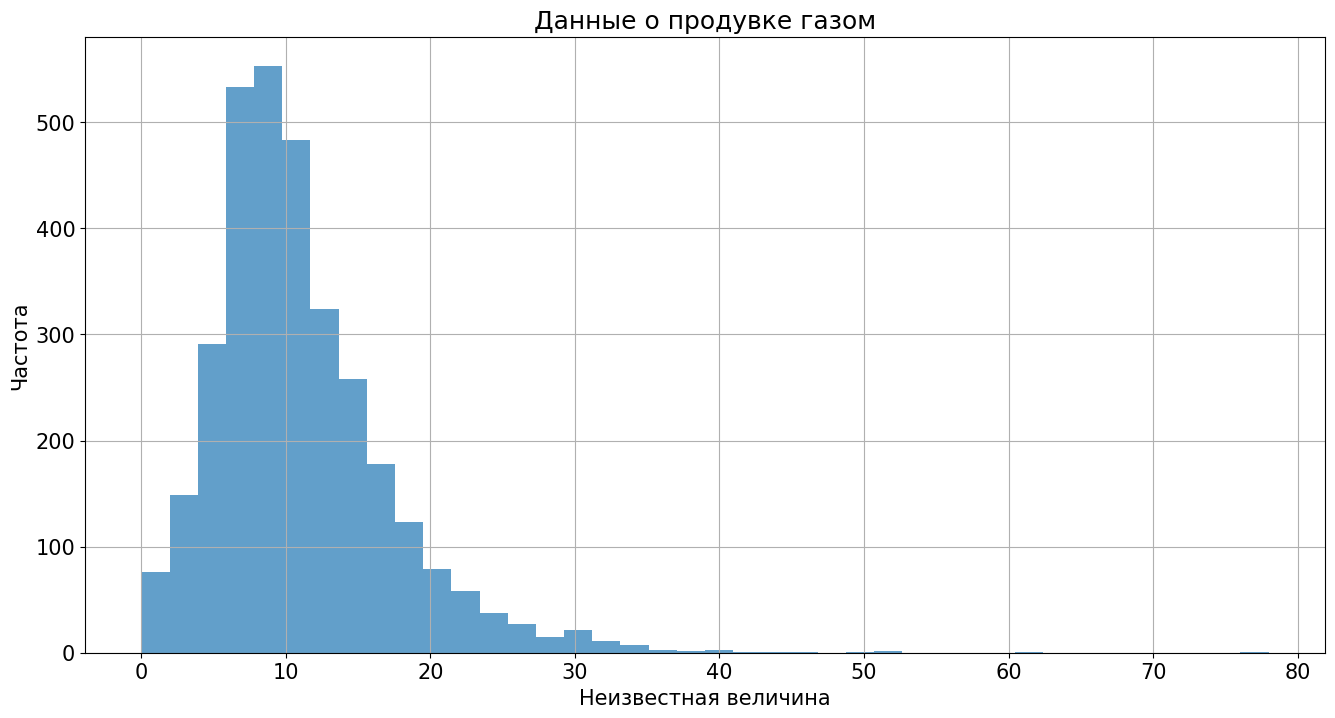

In [28]:
plt.hist(data_gas['Газ 1'], bins=40, alpha=.7)
plt.xlabel('Неизвестная величина')
plt.ylabel('Частота')
plt.title('Данные о продувке газом')
plt.grid(True)
plt.show()

**Из основных преимуществ, благодаря которым стала популярной аргонная продувка, следует выделить:**

* Дегазация расплава (за счет снижения концентрации водорода и азота)
* Небольшое контролируемое охлаждение расплава (не более чем на 15 градусов)
* Ускорение плавления присадок в ковше, обеспечивающих раскисление и легирование металла.
* Раскисление и сильное разуглероживание металлического расплава
* Достижение однородности расплава как по температуре, так и по химическому составу.

 Важные момменты — контроль охлаждения и ускорение плавления присадок. Учитывая, что задача исследования — предикт температуры, данные по газу имеют вес.

**Вывод:**
* пока не ясно, что тут измеряли, единицы "чего" нам даны, нужно узнавать у бизнеса
* распределение близкое к нормальному, есть небольшое смещение влево

### 1.1.4 Результаты измерения температуры <a name="paragraph5"></a>

In [29]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [30]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [31]:
data_temp.info()
data_temp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


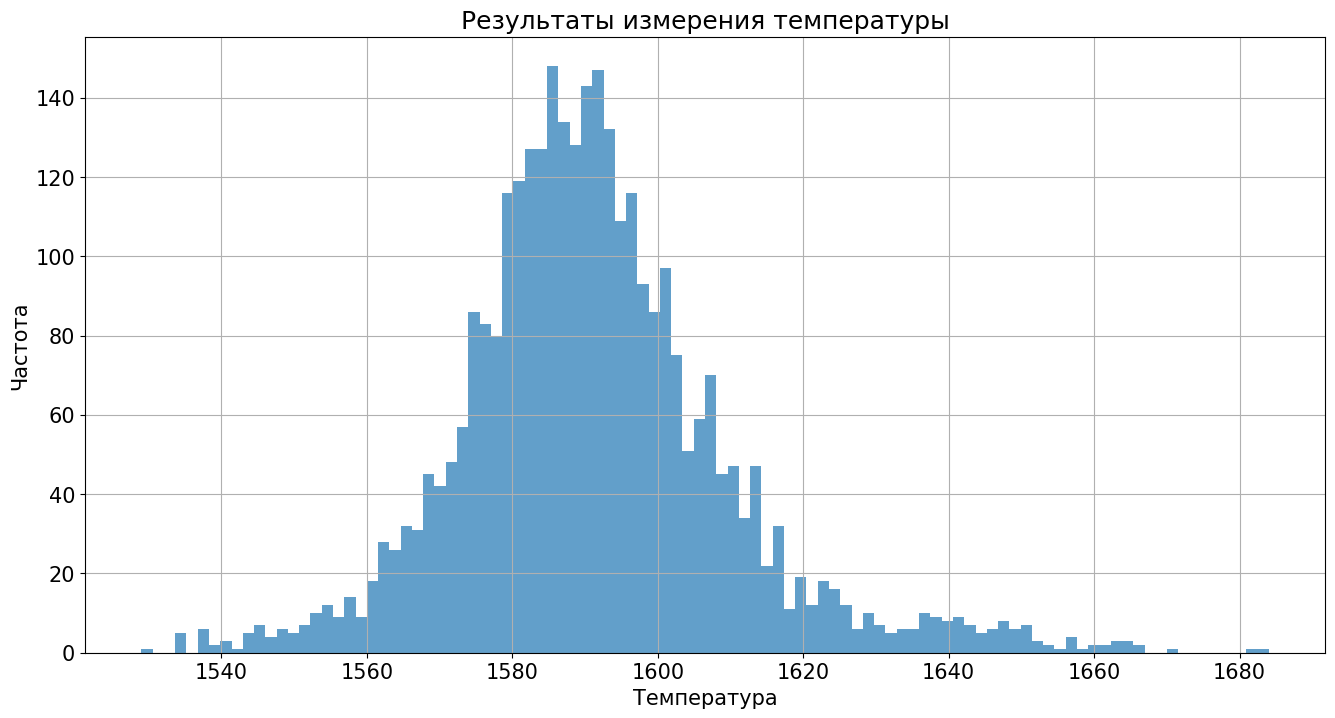

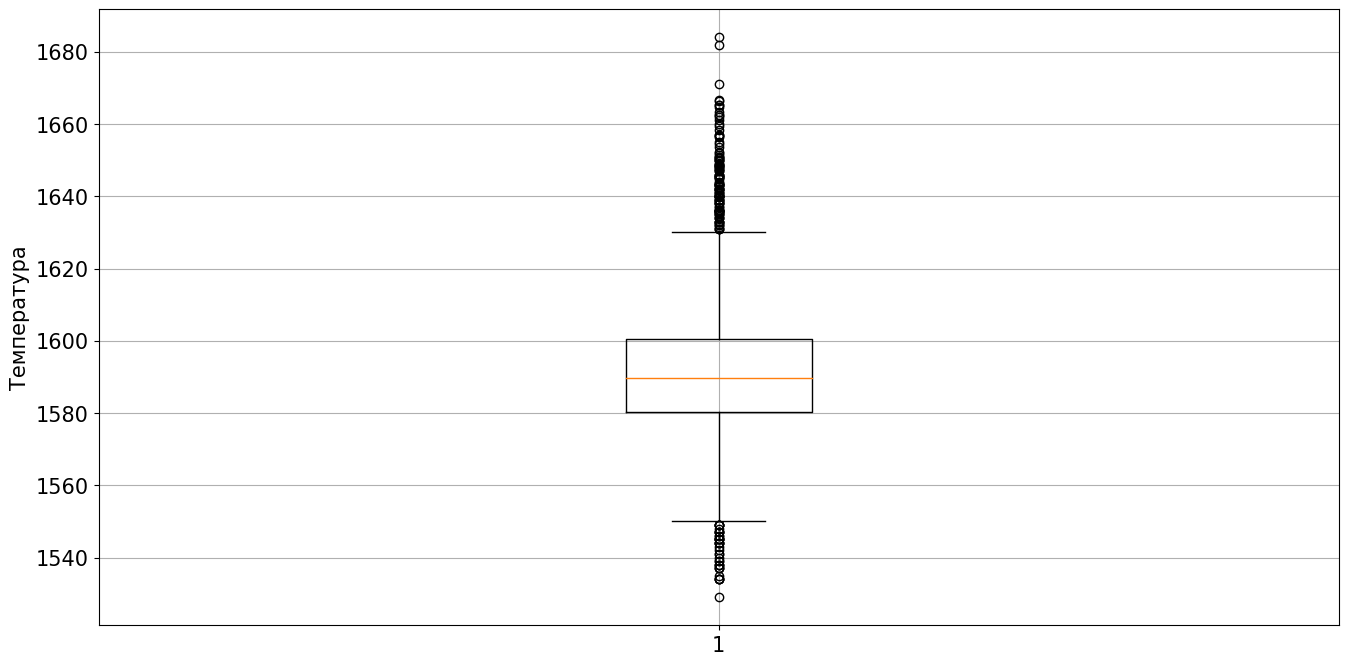

In [32]:
temp = pd.pivot_table(data_temp.query('Температура > 1500'), index='key',
                      values='Температура', aggfunc='mean')
plt.hist(temp, bins=100, alpha=.7)
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.title('Результаты измерения температуры')
plt.grid(True)
plt.show()
plt.boxplot(temp)
plt.ylabel('Температура')
plt.grid(True)
plt.show()

**Уберу значения температуры < 1400**

In [33]:
data_temp = data_temp.query('Температура >= 1400')

**Вывод:**
* распределение близкое к нормальному, есть смещение влево
* большая часть значений находится в межквартильном размахе и равна ~1580°, что соответствует реальной температуре плавления
* это целевое значение, которое буду предсказывать

### 1.1.5 Данные о проволочных материалах (объём) <a name="paragraph6"></a>

In [34]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
data_wire.info()
data_wire.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


### Данные о проволочных материалах (время)

In [36]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_wire_time.info()
data_wire_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


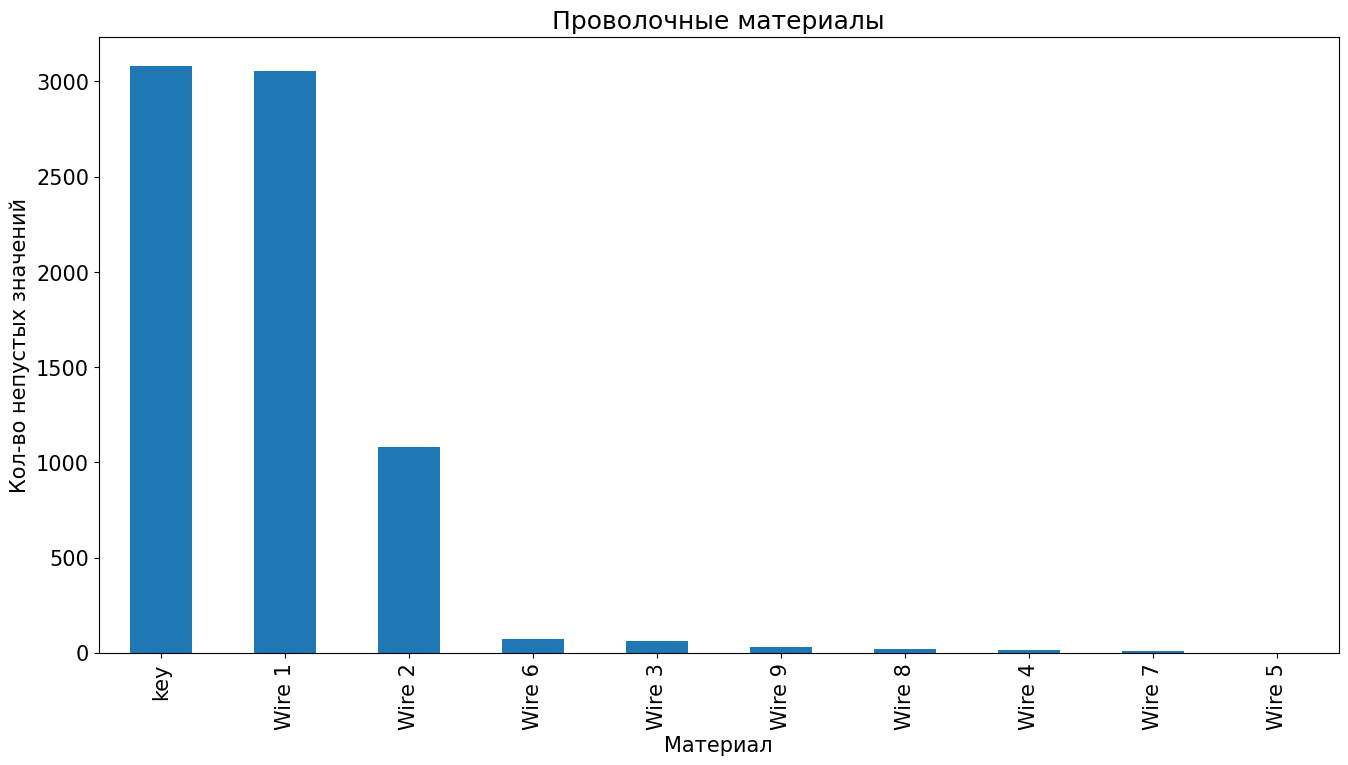

In [38]:
data_wire_time.notnull().sum().sort_values(ascending=False).plot(kind = 'bar')
plt.xlabel('Материал')
plt.ylabel('Кол-во непустых значений')
plt.title('Проволочные материалы')
plt.show()

**Вывод:**
* датасеты data_wire и data_wire_time идентичны и связаны по колонке key
* данные о материалах с 3 по 9 практически отстутствуют
* исправить пропуски невозможно, т.к. эти материалы не использовали в работе
* в производстве преимущественно используют материалы Wire 1 и Wire 2

## Предобработка признаков

Переименую колонки

In [39]:
data_arc.columns = ['key', 'arc_heating_start_dttm', 'arc_heating_end_dttm', 'active_power', 'reactive_power']
data_gas.columns = ['key', 'gas']
data_temp.columns = ['key', 'measurement_time', 'temperature']

### Заполню пропуски нулевым значением

In [40]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

In [41]:
data_bulk.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0


### Добавлю новые признаки и установлю key в качестве индекса

In [42]:
data_arc['heating_duration'] = (data_arc['arc_heating_end_dttm'] - data_arc['arc_heating_start_dttm']).dt.total_seconds()
data_arc['average_heating_time'] = data_arc.groupby('key')['heating_duration'].transform('mean')

In [43]:
temp_col_1 = data_arc.groupby('key')['heating_duration'].sum()
temp_col_2 = data_arc.groupby('key')['average_heating_time'].mean()

**Вычислю полную мощность по формуле и просуммирую ее по партии**

In [44]:
data_arc = data_arc[data_arc['reactive_power'] > 0]

data_arc['total_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**.5

data_arc = data_arc.groupby('key').agg({'total_power': 'sum'})
data_arc.columns = ['total_power']

<ipython-input-44-d63eff551ade>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['total_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**.5


In [45]:
data_arc['heating_duration'] = temp_col_1
data_arc['average_heating_time'] = temp_col_2

In [46]:
data_arc.head(3)

,total_power,heating_duration,average_heating_time
key,,,
1,3.718736,1098.0,219.60
2,2.588349,811.0,202.75
3,5.019223,655.0,131.00


In [47]:
data_bulk.set_index('key', inplace=True)
data_gas.set_index('key', inplace=True)
data_wire.set_index('key', inplace=True)

In [48]:
data_bulk.head(3)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0


**Вычислю дельту между началом и концом замера температуры. Преобразую значения в секунды и сделаю новый столбец**

In [49]:
data_temp['time_delta'] = data_temp.groupby('key')['measurement_time'].transform(lambda x: x.max() - x.min()).dt.total_seconds()

**Найду первый замер и последнюю известную температуру для каждой партии**

In [50]:
data_temp['first_known_temperature'] = data_temp.groupby('key')['temperature'].transform('first')

In [51]:
data_temp = data_temp.groupby('key').last().reset_index()

In [52]:
data_temp = data_temp.query('time_delta > 0')

In [53]:
data_temp.set_index('key', inplace=True)

In [54]:
data_temp.rename(columns={'temperature': 'last_known_temperature'}, inplace=True)

In [55]:
data_temp

,measurement_time,last_known_temperature,time_delta,first_known_temperature
key,,,,
1,2019-05-03 11:30:38,1613.0,1714.0,1571.0
2,2019-05-03 11:55:09,1602.0,1265.0,1581.0
3,2019-05-03 12:35:57,1599.0,1753.0,1596.0
4,2019-05-03 12:59:47,1625.0,1220.0,1601.0
5,2019-05-03 13:36:39,1602.0,1536.0,1576.0
...,...,...,...,...
2495,2019-08-10 11:50:47,1591.0,1380.0,1570.0
2496,2019-08-10 12:25:13,1591.0,1705.0,1554.0
2497,2019-08-10 12:53:28,1589.0,962.0,1571.0


### Объединю таблицы в одну по индексу

In [56]:
frames = [data_arc, data_gas, data_wire, data_bulk, data_temp]
df = pd.concat(frames, axis=1, join='inner')

In [57]:
df.shape

(2329, 32)

In [58]:
df = df.drop('measurement_time', axis=1)

In [59]:
df['first_known_temperature'] = df['first_known_temperature'].astype(int)
df['last_known_temperature'] = df['last_known_temperature'].astype(int)

In [60]:
df['total_wire_materials'] = df[['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6']].sum(axis=1)

df['total_bulk_materials'] = df[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
                               'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
                               'Bulk 14', 'Bulk 15']].sum(axis=1)

In [61]:
df

,total_power,heating_duration,average_heating_time,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,last_known_temperature,time_delta,first_known_temperature,total_wire_materials,total_bulk_materials
key,,,,,,,,,,,,,,,,,,,,,
1,3.718736,1098.0,219.600000,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,206.0,0.0,150.0,154.0,1613,1714.0,1571,60.059998,553.0
2,2.588349,811.0,202.750000,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,206.0,0.0,149.0,154.0,1602,1265.0,1581,96.052315,582.0
3,5.019223,655.0,131.000000,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,205.0,0.0,152.0,153.0,1599,1753.0,1596,91.160157,544.0
4,3.400038,741.0,185.250000,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,207.0,0.0,153.0,154.0,1625,1220.0,1601,89.063515,595.0
5,2.816980,869.0,217.250000,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,203.0,0.0,151.0,152.0,1602,1536.0,1576,98.352796,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.868721,723.0,180.750000,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,256.0,0.0,129.0,223.0,1591,1380.0,1570,89.150879,719.0
2496,5.070316,940.0,156.666667,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,256.0,0.0,129.0,226.0,1591,1705.0,1554,114.179527,796.0
2497,4.360918,569.0,189.666667,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,230.0,0.0,124.0,226.0,1589,962.0,1571,103.134723,665.0


### Проверю распределения у признаков после объединения таблиц

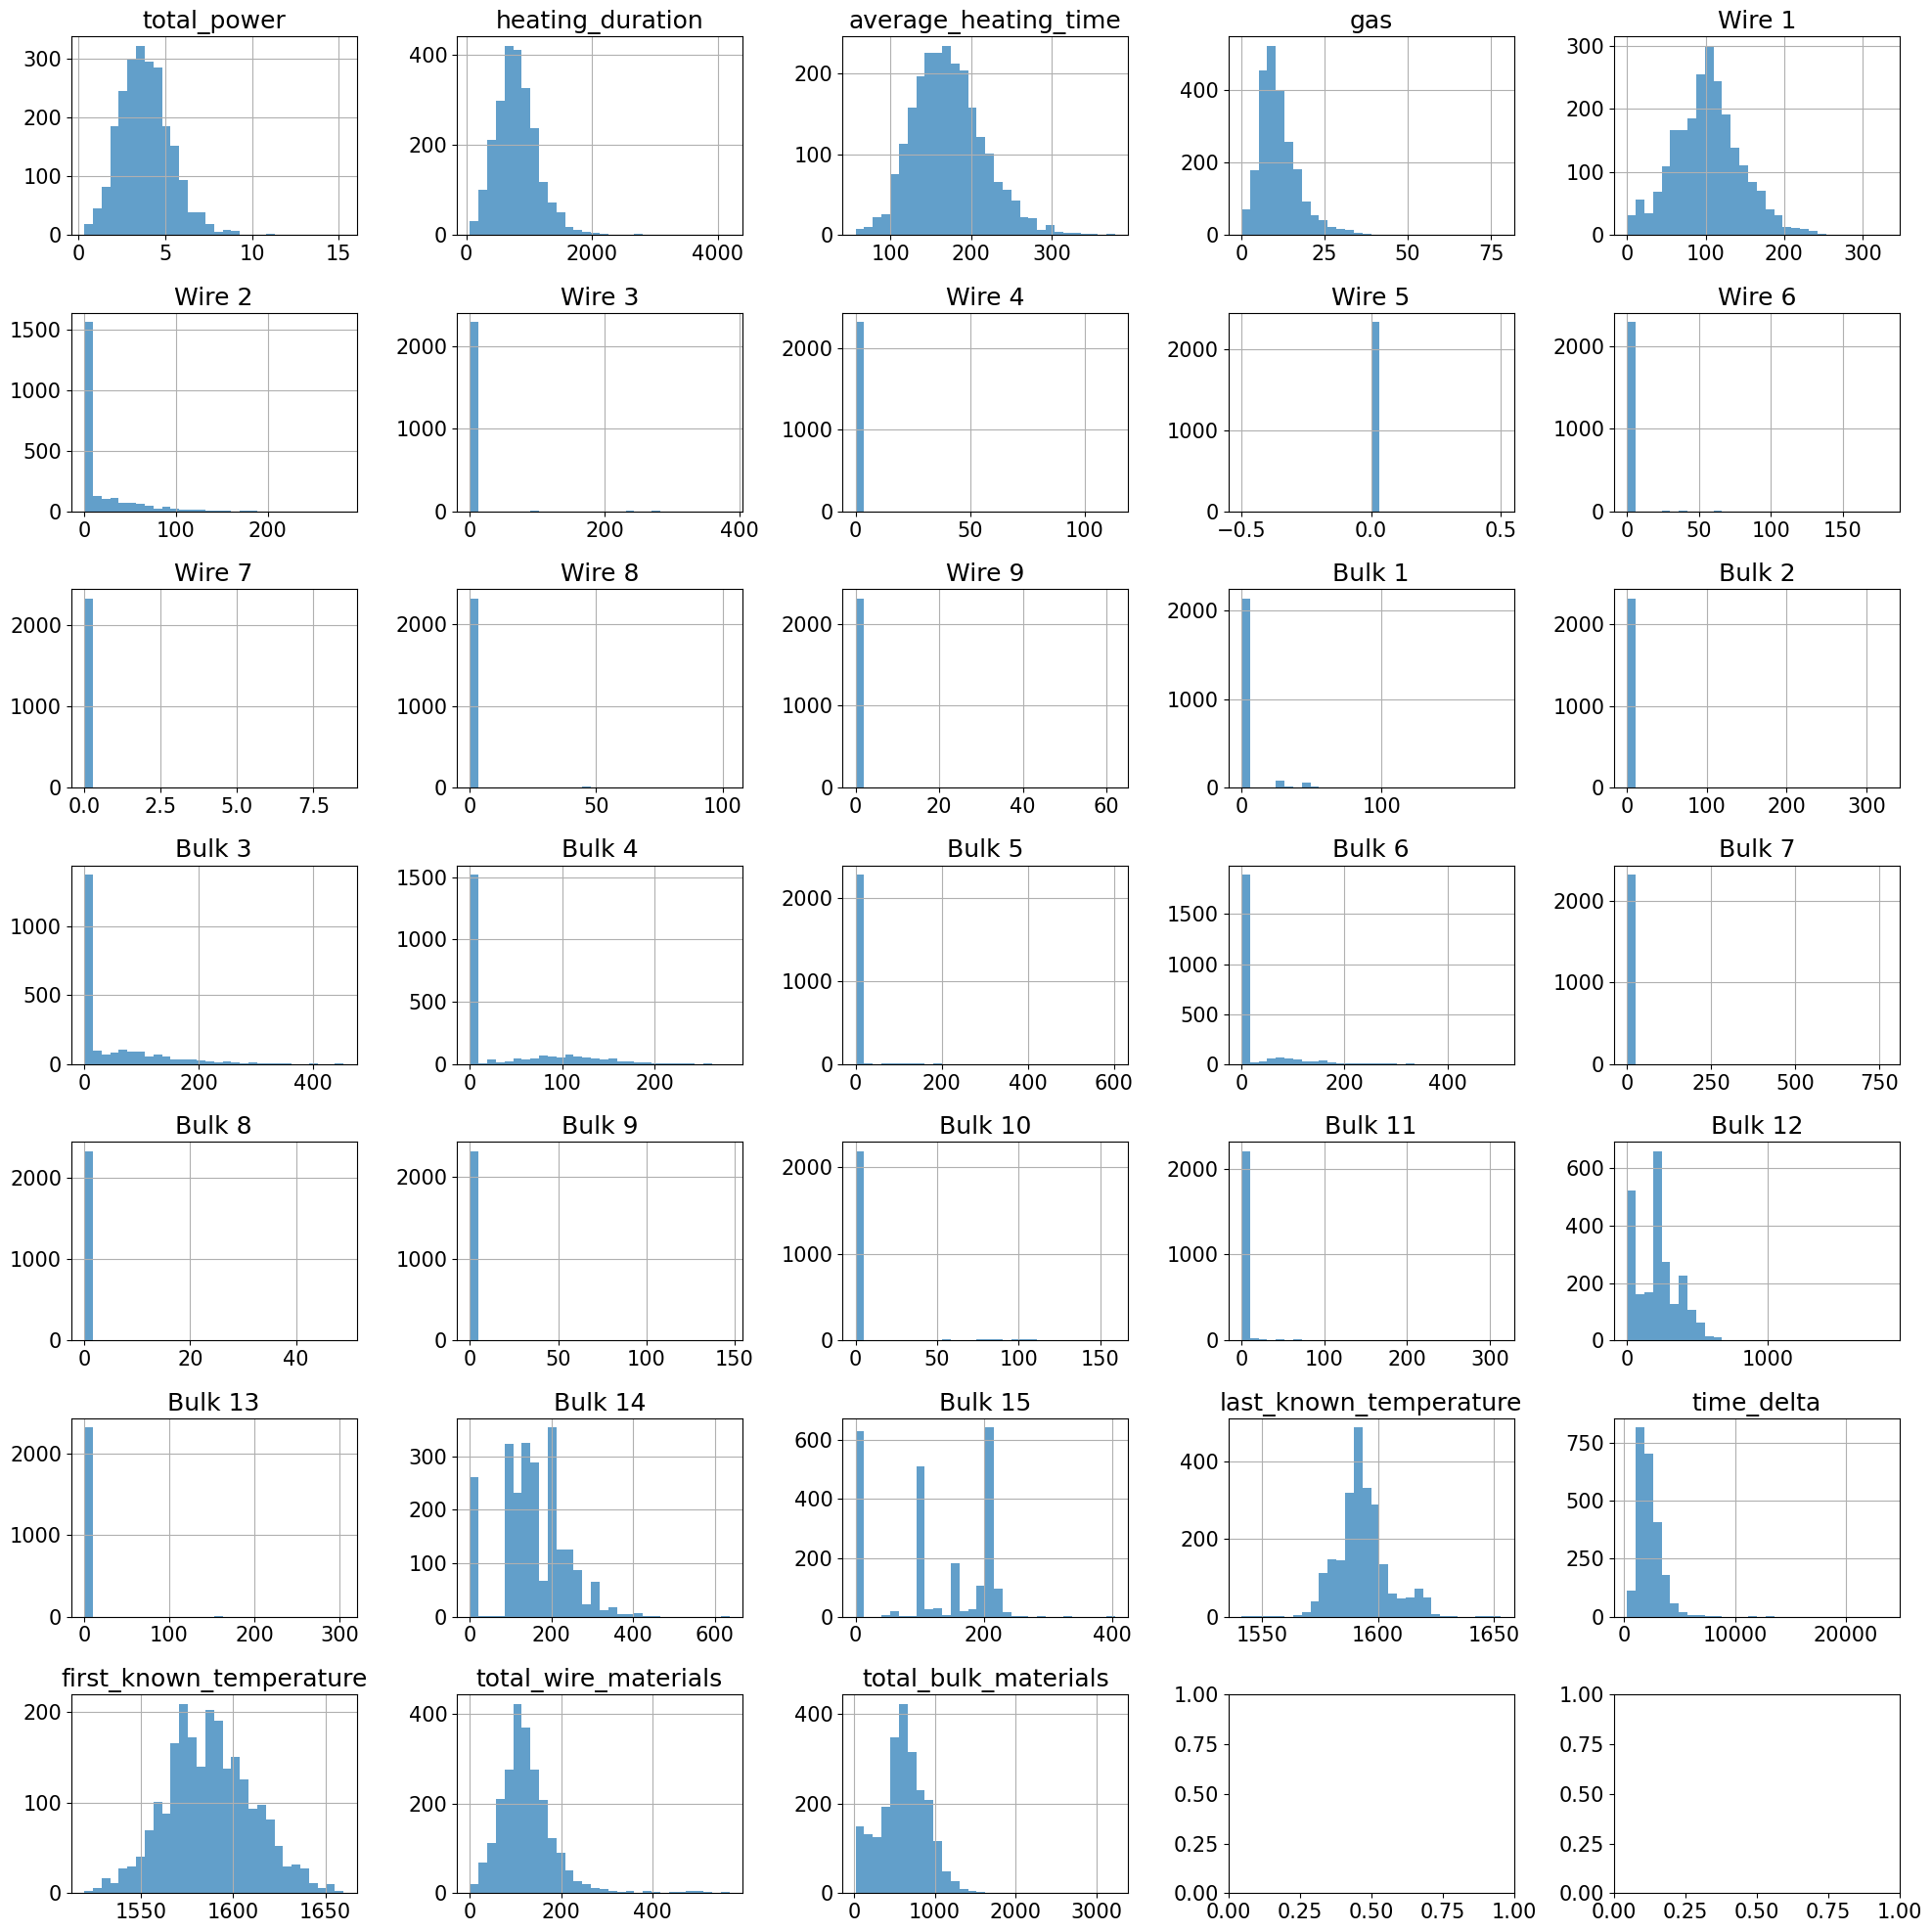

In [62]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))

for i, column in enumerate(df.columns):
    row, col = i // 5, i % 5
    axes[row, col].hist(df[column], bins=30, alpha=0.7)
    axes[row, col].set_title(column)
    axes[row, col].grid(True)
plt.tight_layout()
plt.show()

### Сделаю проверку на мультиколлинеарность

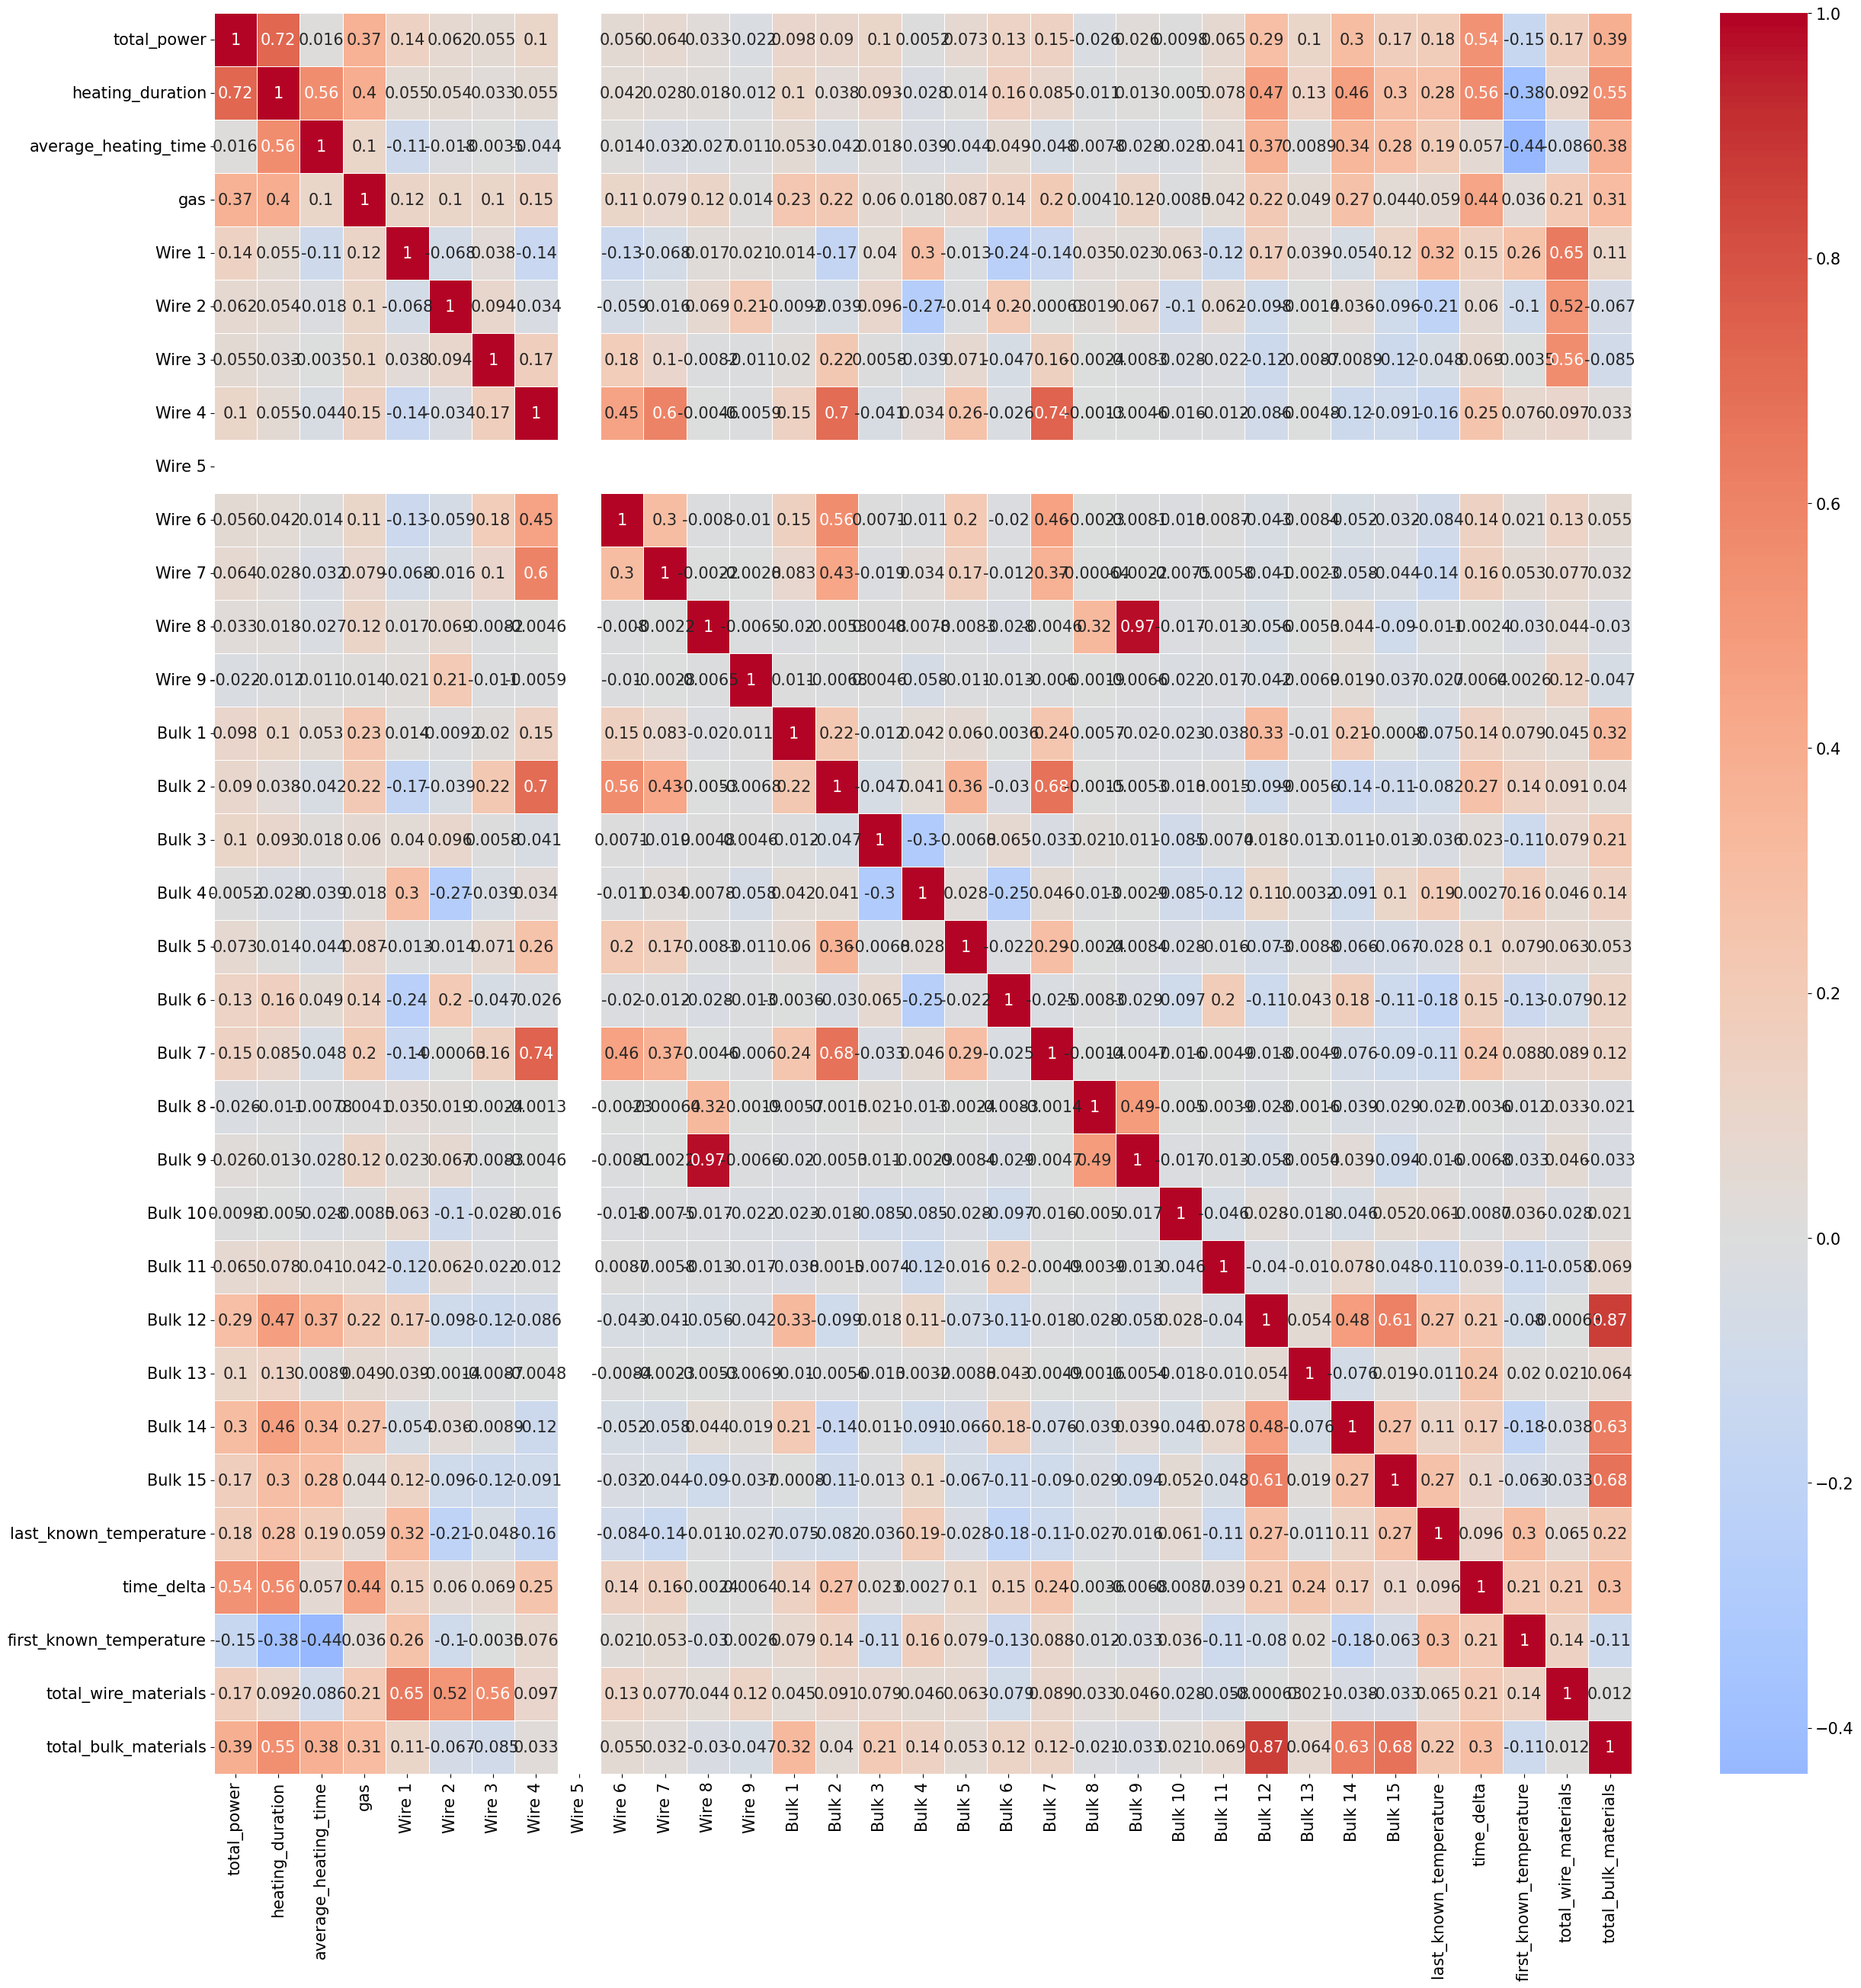

In [63]:
correlation_matrix = df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()

Высокая корреляция между Bulk 9 и Wire 8, Bulk 7 и Bulk 2, total_bulk_materials и Bulk 12. Удалю по одной колонке.

У Wire 5 нет значений, эту колонку тоже удалю.

In [64]:
df = df.drop('Wire 8', axis=1)
df = df.drop('Bulk 7', axis=1)
df = df.drop('Wire 5', axis=1)
df = df.drop('Bulk 12', axis=1)

In [65]:
df.head()

,total_power,heating_duration,average_heating_time,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,...,Bulk 10,Bulk 11,Bulk 13,Bulk 14,Bulk 15,last_known_temperature,time_delta,first_known_temperature,total_wire_materials,total_bulk_materials
key,,,,,,,,,,,,,,,,,,,,,
1,3.718736,1098.0,219.60,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,150.0,154.0,1613,1714.0,1571,60.059998,553.0
2,2.588349,811.0,202.75,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,149.0,154.0,1602,1265.0,1581,96.052315,582.0
3,5.019223,655.0,131.00,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,152.0,153.0,1599,1753.0,1596,91.160157,544.0
4,3.400038,741.0,185.25,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,153.0,154.0,1625,1220.0,1601,89.063515,595.0
5,2.816980,869.0,217.25,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,151.0,152.0,1602,1536.0,1576,98.352796,584.0


**Вывод:**
* переименовал колонки
* добавил новые признаки
* объединил все таблицы в одну
* после объединения данные не повредились
* сделал проверку на мультиколлинеарность — убрал 4 колонки с высокой корреляцией и 1 пустую колонку

## Подготовка к обучению

### Разобью датасет на выборки

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('last_known_temperature', axis=1), df['last_known_temperature'], test_size=.25, random_state=170723)

In [67]:
X_train.shape

(1746, 28)

In [68]:
X_test.shape

(583, 28)

## Обучение моделей

### RandomForest

In [69]:
# parameters = {'n_estimators': [500, 700, 1000],
#               'max_depth' : [8, 10, 14]}

# rfrmodel = RandomForestRegressor(random_state=170723)

# tuning_rfrmodel = GridSearchCV(
#     rfrmodel,
#     param_grid=parameters,
#     cv=5,
#     n_jobs=-1,
#     scoring='neg_mean_absolute_error')

# tuning_rfrmodel.fit(X_train, y_train)

In [70]:
# print(tuning_rfrmodel.best_params_)
# print(-tuning_rfrmodel.best_score_)

```python
parameters = {'n_estimators': [500, 700, 1000],
              'max_depth' : [8, 10, 14]}

rfrmodel = RandomForestRegressor(random_state=170723)

tuning_rfrmodel = GridSearchCV(
    rfrmodel,
    param_grid=parameters,   
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error')

tuning_rfrmodel.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=170723),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 14],
                         'n_estimators': [500, 700, 1000]},
             scoring='neg_mean_absolute_error')
```

```python
print(tuning_rfrmodel.best_params_)
print(-tuning_rfrmodel.best_score_)

{'max_depth': 14, 'n_estimators': 700}
6.212843883482417
```

### Catboost

In [71]:
# parameters =  {'depth': [8, 10, 12],
#                 'l2_leaf_reg': [5, 7, 10]}

# catboostmodel = CatBoostRegressor(random_state=170723, verbose=False)

# tuning_catboostmodel = GridSearchCV(catboostmodel,
#                        param_grid=parameters,
#                        cv=5,
#                        n_jobs=-1,
#                        scoring='neg_mean_absolute_error')
# tuning_catboostmodel.fit(X_train, y_train)

In [72]:
# print(tuning_catboostmodel.best_params_)
# print(-tuning_catboostmodel.best_score_)

```python
parameters =  {'depth': [8, 10, 12],
               'l2_leaf_reg': [5, 7, 10]}

catboostmodel = CatBoostRegressor(random_state=170723, verbose=False)

tuning_catboostmodel = GridSearchCV(catboostmodel,
                       param_grid=parameters,
                       cv=5,
                       n_jobs=-1,
                       scoring='neg_mean_absolute_error')

tuning_catboostmodel.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002A85F03CC10>,
             n_jobs=-1,
             param_grid={'depth': [8, 10, 12], 'l2_leaf_reg': [5, 7, 10]},
             scoring='neg_mean_absolute_error')
```

```python
print(tuning_catboostmodel.best_params_)
print(-tuning_catboostmodel.best_score_)

{'depth': 8, 'l2_leaf_reg': 10}
5.9390804675841675

```

### LightGBM

In [73]:
# parameters = {'max_depth': [None] + [i for i in range(6, 24)],
#               'n_estimators': [100, 500, 1000, 1500],
#                'learning_rate': [0.01]}

# lgbmr = lgb.LGBMRegressor(random_state=170723)

# tuning_model_lgbmr = GridSearchCV(lgbmr,
#                                   param_grid=parameters,
#                                   cv=5,
#                                   n_jobs=-1,
#                                   scoring='neg_mean_absolute_error')


# tuning_model_lgbmr.fit(X_train, y_train)

In [74]:
# print(tuning_model_lgbmr.best_params_)
# print(-tuning_model_lgbmr.best_score_)

```python
parameters = {'max_depth': [None] + [i for i in range(6, 24)],
              'n_estimators': [100, 500, 1000, 1500],
               'learning_rate': [0.01]}

lgbmr = lgb.LGBMRegressor(random_state=170723)

tuning_model_lgbmr = GridSearchCV(lgbmr,
                                  param_grid=parameters,
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='neg_mean_absolute_error')
                                
                            
tuning_model_lgbmr.fit(X_train, y_train)
                            
GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=170723), n_jobs=-1,
             param_grid={'learning_rate': [0.01],
                         'max_depth': [None, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20, 21, 22, 23],
                         'n_estimators': [100, 500, 1000, 1500]},
             scoring='neg_mean_absolute_error')
```

```python
print(tuning_model_lgbmr.best_params_)
print(-tuning_model_lgbmr.best_score_)
{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1500}
5.924723860053892
```

### Тестирование модели LightGBM

In [75]:
lgbmr = lgb.LGBMRegressor(random_state=170723,
                          learning_rate=.01,
                          max_depth=16,
                          n_estimators=500)
lgbmr.fit(X_train, y_train)

y_pred_lgbmr = lgbmr.predict(X_test)
print(f'MAE = {mean_absolute_error(y_test, y_pred_lgbmr)}')

MAE = 6.0342121576434025


In [76]:
data = {'Model': ['RandomForest', 'CatBoost', 'LightGBM'],
        'MAE on train': [6.21, 5.93, 5.92],
        'MAE on test': ['-', '-', 6.03]}
result = pd.DataFrame(data)
result

,Model,MAE on train,MAE on test
0,RandomForest,6.21,-
1,CatBoost,5.93,-
2,LightGBM,5.92,6.03


### Посмотрю значимость признаков

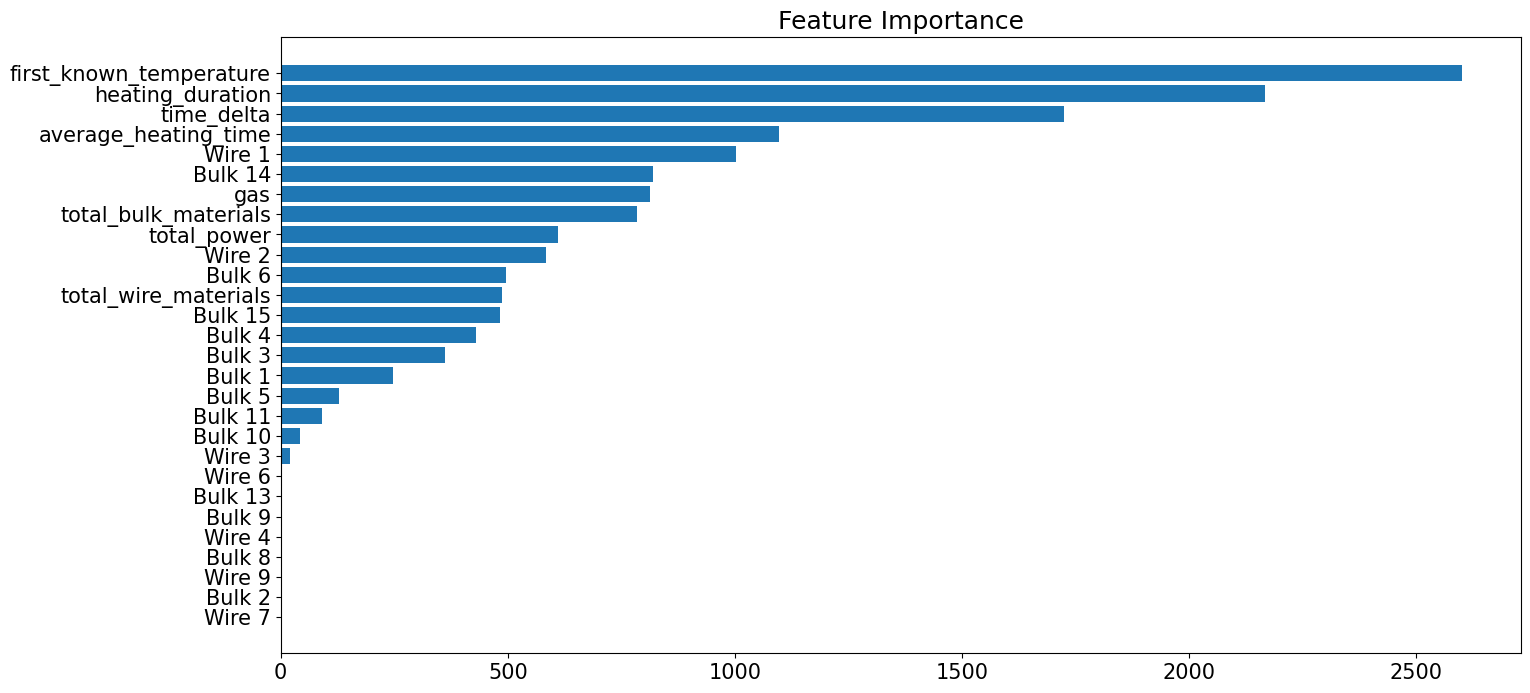

In [77]:
feature_importance = lgbmr.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

Наибольшую важность имеют признаки, которые я добавлял в процессе работы.

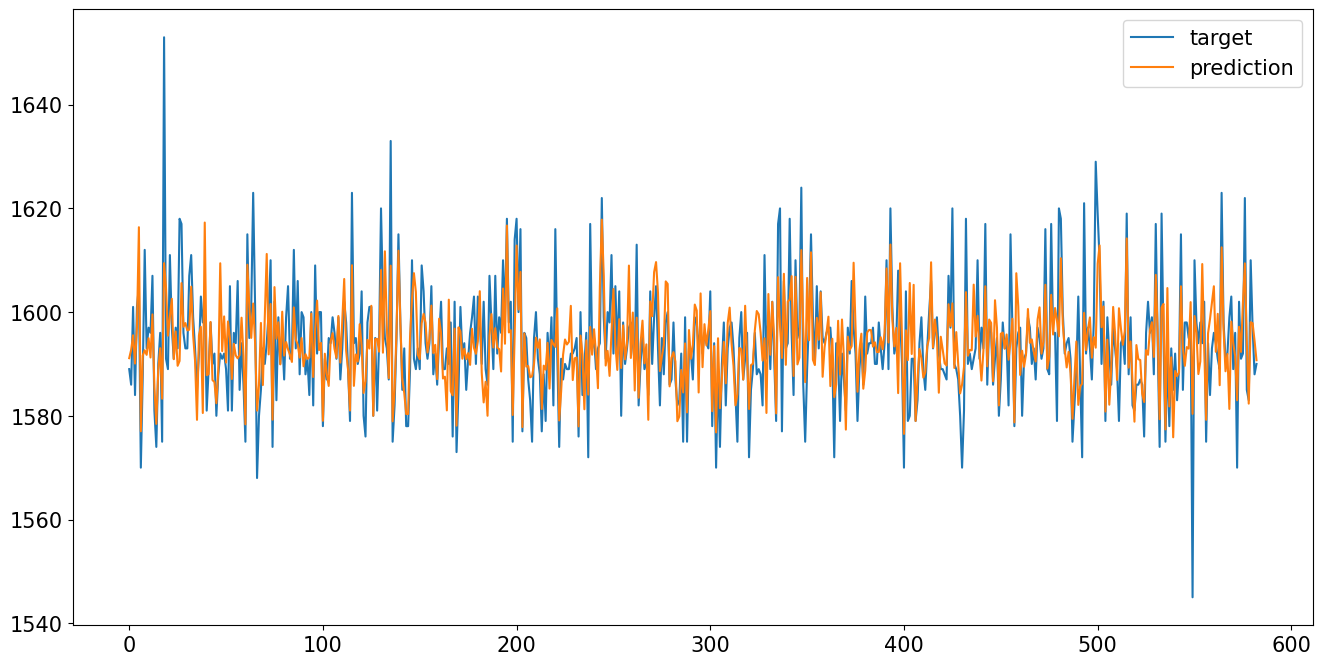

In [78]:
a = y_test.to_list()
b = list(y_pred_lgbmr)

plt.plot(a, label='target')
plt.plot(b, label='prediction')
plt.legend()
plt.show()

## Вывод

* В этом проекте я применил 3 модели машинного обучения. Все они дали хороший результат и пригодны к использованию. Лучший показатель у LightGBM.
* Работа с гиперпараметрами не давала значительного прироста MAE. При высоких значениях кратно росло время обучения, но метрика не становилась лучше, модель переобучалась.
* На графике Feature Importance видно, что признаки, которые я добавил в процессе работы, оказали наибольшее влияние на результат
* На результат практически не оказали влияния колонки с большим количеством пропусок. От них можно отказаться.